In [1]:
import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'
os.environ['NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"


In [2]:
import netket as nk

import sys
# sys.path.append('/scratch/samiz/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
# sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
sys.path.append('/scratch/samiz/Model')

import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers6 as vit
from data_extracter import *
import os
from jax import vmap
import flax.linen as nn

nk.config.netket_random_state_fallback_warning = False

In [3]:
L = 10
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,4,5,6,7,8,9,
                   20,21,22,23,24,25,26,27,28,29,
                   40,41,42,43,44,45,46,47,48,49,
                   60,61,62,63,64,65,66,67,68,69,
                   80,81,82,83,84,85,86,87,88,89]
}

sublatt_J2 = [0,1,2,3,4,5,6,7,8,9,
                   20,21,22,23,24,25,26,27,28,29,
                   40,41,42,43,44,45,46,47,48,49,
                   60,61,62,63,64,65,66,67,68,69,
                   80,81,82,83,84,85,86,87,88,89]

Ha, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)


pHa['sublattice'] = sublattice(L)
Ha_SSJ3 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)


XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()
sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)
rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=64, sweep_size=3*hi2d.size)


In [4]:
def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi2d).to_jax_operator()

In [6]:
pVit = {
    'd': 32,
    'h': 8,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 5,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,10,11,20,21,30,31,40,41], [2,3,12,13,22,23,32,33,42,43],
                                         [4,5,14,15,24,25,34,35,44,45], [6,7,16,17,26,27,36,37,46,47],
                                         [8,9,18,19,28,29,38,39,48,49], [50,51,60,61,70,71,80,81,90,91], 
                                         [52,53,62,63,72,73,82,83,92,93], [54,55,64,65,74,75,84,85,94,95], 
                                         [56,57,66,67,76,77,86,87,96,97], [58,59,68,69,78,79,88,89,98,99],
                                         ]))
    }

patch_transl = HashableArray(vit.get_translation(L, L, L**2, pVit['Cx'], pVit['Cy']))

m_Vit = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl, recover_spin_flip_symm=True)



ID = np.arange(0, 100)
R = vit.make_first_reflection(ID, L)
Glide_Rot = vit.rot180_trans1(ID, L)
GRR = vit.trans_product(Glide_Rot, R)
arr = jnp.array([ID, R, Glide_Rot, GRR])

m_Vit_reflect = vit.reflection_wrapper(model=m_Vit, reflections=HashableArray(arr))

In [7]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)
vs_vit_reflect = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit_reflect, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)

vs_vit_J3 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)
vs_vit_J3_reflect = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit_reflect, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)



In [8]:
print(vs_vit.n_parameters)

8056


In [9]:
with open('patching_xy52_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)

vs_vit.variables = ps
m2_pytree = vs_vit_reflect.variables.copy()
m2_pytree['params']['model'] = ps['params']
vs_vit_reflect.variables = m2_pytree


with open('patching_xy52_signstructure/Log_Files_J3/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps_J3 = pickle.load(f)
vs_vit_J3.variables = ps_J3
m2_pytree_J3 = vs_vit_J3_reflect.variables.copy()
m2_pytree_J3['params']['model'] = ps_J3['params']
vs_vit_J3_reflect.variables = m2_pytree_J3


In [10]:
vs_vit.n_samples = 2**14
vs_vit.expect(Ha.to_jax_operator())

-120.3-0.0j ± 4.7 [σ²=1577.9, R̂=1.3829, τ=2.9<32.3]

In [48]:
vs_vit_J3_reflect.reset()

In [49]:
vs_vit_J3_reflect.expect(Mtot)

0.0027+0.0000j ± 0.0024 [σ²=0.0024, R̂=1.1338, τ=0.9<7.6]

In [11]:
print(ps['params']['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'])

print(vs_vit_reflect.parameters['model']['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'])

# print(vs_vit.parameters['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'])

[0.99498087 1.02844997 1.21195752 1.0566987  1.0775828  1.08849671
 1.16618713 1.07446746 1.09244587 1.00440477 1.05890626 1.10727037
 1.71728438 1.03977405 1.23797484 1.06675025 1.03282233 1.05381356
 1.00786622 1.04402132 1.02016745 0.99579368 1.12485795 1.12840028
 1.02343829 1.04056104 1.58436473 1.01791477 1.07370871 1.29775509
 1.05939561 1.05058815]
[0.99498087 1.02844997 1.21195752 1.0566987  1.0775828  1.08849671
 1.16618713 1.07446746 1.09244587 1.00440477 1.05890626 1.10727037
 1.71728438 1.03977405 1.23797484 1.06675025 1.03282233 1.05381356
 1.00786622 1.04402132 1.02016745 0.99579368 1.12485795 1.12840028
 1.02343829 1.04056104 1.58436473 1.01791477 1.07370871 1.29775509
 1.05939561 1.05058815]


In [43]:
vs_vit_J3_reflect.expect(Ha_SSJ3.to_jax_operator())

-136.7-0.0j ± 2.2 [σ²=630.5, R̂=1.2938, τ=2.4<8.1]

In [122]:
for j in range(100):
    vs_vit.reset()

In [13]:
vs_vit.expect(Ha.to_jax_operator())

-116.0-0.0j ± 4.8 [σ²=1694.0, R̂=1.3792, τ=1.4<7.8]

In [8]:
pVit_deep = {
    'd': 32,
    'h': 8,
    'nl': 6,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 5,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,10,11,20,21,30,31,40,41], [2,3,12,13,22,23,32,33,42,43],
                                         [4,5,14,15,24,25,34,35,44,45], [6,7,16,17,26,27,36,37,46,47],
                                         [8,9,18,19,28,29,38,39,48,49], [50,51,60,61,70,71,80,81,90,91], 
                                         [52,53,62,63,72,73,82,83,92,93], [54,55,64,65,74,75,84,85,94,95], 
                                         [56,57,66,67,76,77,86,87,96,97], [58,59,68,69,78,79,88,89,98,99],
                                         ]))
}

patch_transl = HashableArray(vit.get_translation(L, L, L**2, pVit['Cx'], pVit['Cy']))

m_Vit_deep = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit_deep['patch_arr']), embed_dim=pVit_deep['d'], num_heads=pVit_deep['h'], nl=pVit_deep['nl'],
                                Dtype=pVit_deep['Dtype'], L=pVit_deep['L'], Cx=pVit_deep['Cx'], Cy=pVit_deep['Cy'], hidden_density=pVit_deep['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl, recover_spin_flip_symm=True)


ID = np.arange(0, L**2)
R = vit.make_first_reflection(ID, L)
Glide_Rot = vit.rot180_trans1(ID, L)
GRR = vit.trans_product(Glide_Rot, R)
arr = jnp.array([ID, R, Glide_Rot, GRR])

m_Vit_deep_reflect = vit.reflection_wrapper(model=m_Vit_deep, reflections=HashableArray(arr))


vs_vit_nl6 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit_deep, n_samples=2**12, n_discard_per_chain=16)
vs_vit_nl6_reflect = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit_deep_reflect, n_samples=2**12, n_discard_per_chain=16)
print(vs_vit_nl6.n_parameters)

35696


In [ ]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/10x10_ViT_RBM_Refined_Learning/patching_xy52_signstructure_nl_6/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:
     ps6 = pickle.load(handle)
     
vs_vit_nl6.variables = ps6
m2_pytree6 = vs_vit_nl6_reflect.variables.copy()
m2_pytree6['params']['model'] = ps6['params']
vs_vit_nl6_reflect.variables = m2_pytree6

In [12]:
class rbm_trans_flip(nn.Module):
    translations: jnp.ndarray
    alpha : float
    param_dtype: Any = jnp.dtype

    @nn.compact
    def __call__(self, x):
        rbm = nk.models.RBM(alpha=self.alpha, param_dtype=self.param_dtype)

        x = jnp.apply_along_axis(lambda elt: jnp.array([rbm(x[...,elt]), rbm(-x[...,elt])]), axis = -1, arr =jnp.asarray(self.translations))
        x = x.reshape(-1,x.shape[-1])
        return logsumexp_cplx(x, axis = 0)

In [13]:
lattice_trans = vit.get_translation(L,L,L**2,L,L)
m_rbm = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=1, param_dtype=complex)
m_rbm2 = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=2, param_dtype=complex)

vs_rbm1_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_rbm, n_samples=2**12, n_discard_per_chain=16)
vs_rbm2_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_rbm2, n_samples=2**12, n_discard_per_chain=16)

with open('10x10_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha1.0_transflip_SS.pickle', 'rb') as f:
    vs_rbm1_SS.variables = pickle.load(f)

with open('10x10_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha2.0_transflip_SS.pickle', 'rb') as f:
    vs_rbm2_SS.variables = pickle.load(f)

In [13]:
print(vs_rbm1_SS.n_parameters)

10200


### Plot Energy and Vscore for rbm and vit

In [12]:
path_vit52 = 'patching_xy52_signstructure/Log_Files'
path_rbm = '10x10_XYZ_RBM/Log_Files'

data = {}
extract_data([f for f in os.listdir(path_vit52) if '.log' in f], data, path_vit52, ['log_vit_sampler_HaEx_5050'], ['vit52'], L=10)
extract_data([f for f in os.listdir(path_rbm) if '.log' in f], data, path_rbm, ['log_saHaEx5050_'], [''], L=10)

In [13]:
data.keys()

dict_keys(['vit52', 'vit52_transflip', 'rbm_alpha2.0_SS', 'rbm_alpha1.0_SS', 'rbm_alpha2.0_transflip_SS', 'rbm_alpha1.0_transflip_SS'])

/tmp/ipykernel_364127/1859950921.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


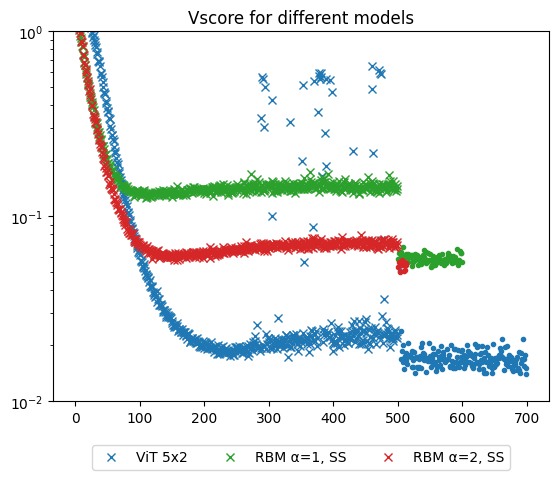

In [14]:
plt.figure()
plt.title('Vscore for different models')

step1 = len(data['vit52']['Vscore'])
plt.semilogy(data['vit52']['Vscore'], marker='x', linestyle='', label='ViT 5x2', color='tab:blue')
step2 = len(data['vit52_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit52_transflip']['Vscore'], marker='.', linestyle='', color='tab:blue')


step1 = len(data['rbm_alpha1.0_SS']['Vscore'])
plt.semilogy(data['rbm_alpha1.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data['rbm_alpha1.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['rbm_alpha1.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:green')

step1 = len(data['rbm_alpha2.0_SS']['Vscore'])
plt.semilogy(data['rbm_alpha2.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=2, SS', color='tab:red')
step2 = len(data['rbm_alpha2.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['rbm_alpha2.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:red')



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(0,1)
plt.show()



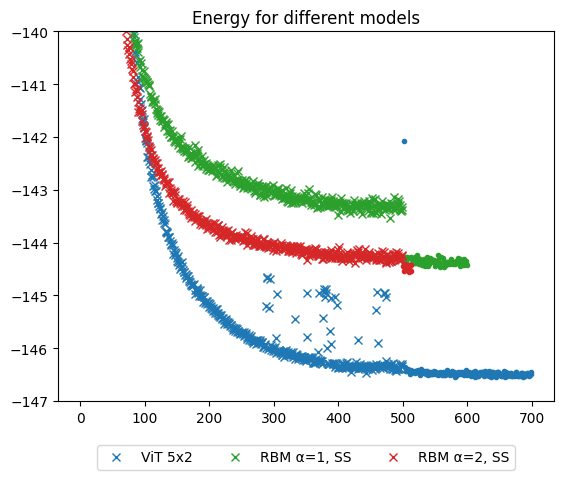

In [15]:
plt.figure()
plt.title('Energy for different models')

step1 = len(data['vit52']['Energy'])
plt.plot(data['vit52']['Energy'], marker='x', linestyle='', label='ViT 5x2', color='tab:blue')
step2 = len(data['vit52_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit52_transflip']['Energy'], marker='.', linestyle='', color='tab:blue')


step1 = len(data['rbm_alpha1.0_SS']['Energy'])
plt.plot(data['rbm_alpha1.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data['rbm_alpha1.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['rbm_alpha1.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:green')

step1 = len(data['rbm_alpha2.0_SS']['Energy'])
plt.plot(data['rbm_alpha2.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=2, SS', color='tab:red')
step2 = len(data['rbm_alpha2.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['rbm_alpha2.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:red')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(-147, -140)
plt.show()


### Compute expected magnetization and energy as well as spin spin correlation as well as spin structure factor

In [25]:
print(data['vit52_transflip']['Energy'][-1], data['vit52_transflip']['Variance'][-1], data['vit52_transflip']['Vscore'][-1])
print(data['rbm_alpha1.0_transflip_SS']['Energy'][-1], data['rbm_alpha1.0_transflip_SS']['Variance'][-1], data['rbm_alpha1.0_transflip_SS']['Vscore'][-1])


-146.48003214979292 3.239641571780668 0.01509851310752977
-144.41527215371943 11.852733606084279 0.05683112629006541


In [17]:
print(vs_vit.expect(Mtot.to_jax_operator()), vs_rbm1_SS.expect(Mtot.to_jax_operator()), vs_rbm2_SS.expect(Mtot.to_jax_operator()))

-0.0000+0.0000j ± 0.0011 [σ²=0.0029, R̂=1.0134, τ=0.8<2.7] 0.00104+0.00000j ± 0.00066 [σ²=0.00192, R̂=1.0067, τ=0.9<2.3] -0.00013+0.00000j ± 0.00072 [σ²=0.00181, R̂=1.0093, τ=0.7<2.9]


In [16]:
SpinSpin_Corrs = {}
SpinSpin_Corrs_Err = {}

def compute_spin_spin_corr(vs, label, make_rotate=False, sublattice=None):
    values = []
    errors = []
    for j in range(1, hi2d.size):
        op = SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator() 
        stats = vs.expect(op)
        values.append(stats.mean)
        errors.append(stats.error_of_mean)
    SpinSpin_Corrs[label] = values
    SpinSpin_Corrs_Err[label] = errors

pHa['sublattice'] = sublatt_J2
compute_spin_spin_corr(vs_vit, 'vit52', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm1_SS, 'rbm1', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm2_SS, 'rbm2', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_vit_reflect, 'vit52_reflect', make_rotate=True, sublattice=pHa['sublattice'])
# compute_spin_spin_corr(vs_vit_nl6, 'vit52_nl6', make_rotate=True, sublattice=pHa['sublattice'])
# compute_spin_spin_corr(vs_vit_nl6_reflect, 'vit52_nl6_reflect', make_rotate=True, sublattice=pHa['sublattice'])

pHa['sublattice'] = sublattice(L)
compute_spin_spin_corr(vs_vit_J3, 'vit52_J3', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_vit_J3_reflect, 'vit52_J3_reflect', make_rotate=True, sublattice=pHa['sublattice'])


In [17]:
vs_vit.n_samples = 2**16
vs_vit.reset()
pHa['sublattice'] = sublatt_J2
compute_spin_spin_corr(vs_vit, 'vit52', make_rotate=True, sublattice=pHa['sublattice'])


compute longest spin spin correlation in a_1 direction

In [34]:
print(vs_vit.expect(SpinSpin(0, 40, hi2d, make_rotation=True, sublattice=sublatt_J2).to_jax_operator() / 3))
print(vs_vit.expect(SpinSpin(0, 60, hi2d, make_rotation=True, sublattice=sublatt_J2).to_jax_operator() / 3))

print(vs_vit_reflect.expect(SpinSpin(0, 40, hi2d, make_rotation=True, sublattice=sublatt_J2).to_jax_operator() / 3))
print(vs_vit_reflect.expect(SpinSpin(0, 60, hi2d, make_rotation=True, sublattice=sublatt_J2).to_jax_operator() / 3))

print(vs_vit_J3_reflect.expect(SpinSpin(0, 40, hi2d, make_rotation=True, sublattice=sublattice(10)).to_jax_operator() / 3))
print(vs_vit_J3_reflect.expect(SpinSpin(0, 60, hi2d, make_rotation=True, sublattice=sublattice(10)).to_jax_operator() / 3))




0.2046-0.0000j ± 0.0018 [σ²=0.1477, R̂=1.0008, τ=1.0<1.4]
0.2068-0.0000j ± 0.0019 [σ²=0.1531, R̂=1.0007, τ=1.0<1.3]
0.2196+0.0007j ± 0.0055 [σ²=0.1684, R̂=1.0045, τ=0.9<2.6]
0.2125-0.0006j ± 0.0072 [σ²=0.1712, R̂=1.0093, τ=0.9<2.0]
0.2217+0.0002j ± 0.0076 [σ²=0.1996, R̂=1.0062, τ=0.7<1.9]
0.2120-0.0001j ± 0.0068 [σ²=0.1464, R̂=1.0089, τ=0.8<1.9]


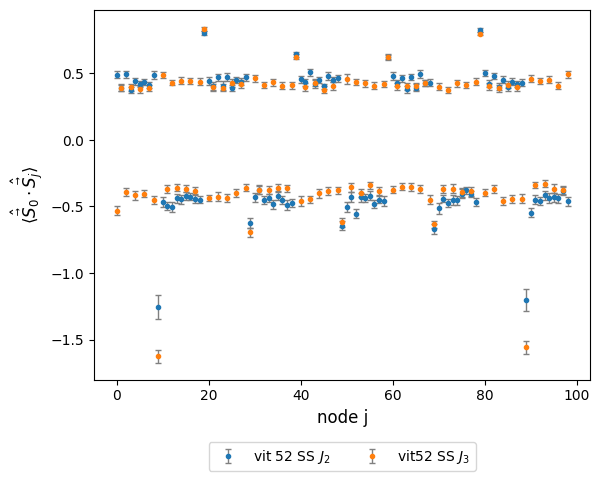

In [27]:
plt.figure()
# plt.title('Spin-spin correlation for different models for 10x10 lattice')
plt.ylabel(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)
plt.xlabel('node j', fontsize=12)
    # plt.plot(np.real(SpinSpin_Corrs[key]), marker='.', linestyle='', label=key)
# plt.errorbar(y=np.real(SpinSpin_Corrs['vit52']), x=jnp.arange(0, len(SpinSpin_Corrs['vit52'])), yerr=SpinSpin_Corrs_Err['vit52'], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label='vit52')
plt.errorbar(y=np.real(SpinSpin_Corrs['vit52_reflect']), x=jnp.arange(0, len(SpinSpin_Corrs['vit52'])), yerr=SpinSpin_Corrs_Err['vit52_reflect'], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label='vit 52 SS $J_2$')
plt.errorbar(y=np.real(SpinSpin_Corrs['vit52_J3']), x=jnp.arange(0, len(SpinSpin_Corrs['vit52_J3'])), yerr=SpinSpin_Corrs_Err['vit52_J3'], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label='vit52 SS $J_3$')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig(fname='SpinSpin_Corss_10x10.png', dpi=300, bbox_inches='tight')
plt.show()

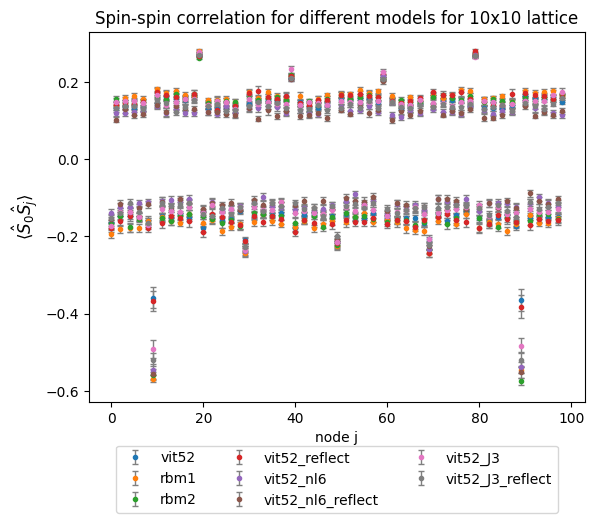

In [19]:
plt.figure()
plt.title('Spin-spin correlation for different models for 10x10 lattice')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs.keys():
    # plt.plot(np.real(SpinSpin_Corrs[key]), marker='.', linestyle='', label=key)
    plt.errorbar(y=np.real(SpinSpin_Corrs[key]), x=jnp.arange(0, len(SpinSpin_Corrs[key])), yerr=SpinSpin_Corrs_Err[key], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label=key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

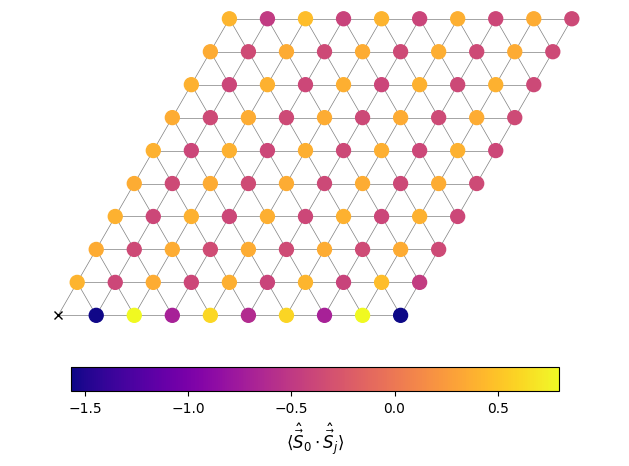

In [19]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
# plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ on 10x10 lattice', loc='center')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
sc = plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit52']), cmap='plasma', s=100, label=' α=1')
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, shrink=0.8)  # Adjust shrink to control size
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)
plt.tight_layout()
# cbar = plt.colorbar(orientation='horizontal', pad=0.2)
# cbar.set_label(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.savefig(fname='SpinSpin_Corrs_vit52_J2_sign.png', dpi=300, bbox_inches='tight')
plt.show()

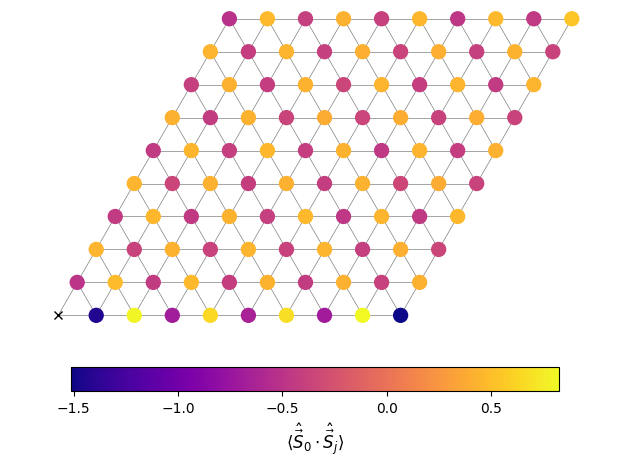

In [18]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
# plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit52 $J_3$ on 10x10 lattice', loc='center')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
sc = plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_J3']), cmap='plasma', s=100, label=' α=1')
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, shrink=0.8)
  # Adjust shrink to control size
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)
plt.tight_layout()

plt.savefig(fname='SpinSpin_Corrs_vit52_J3_sign.png', dpi=300, bbox_inches='tight')
plt.show()

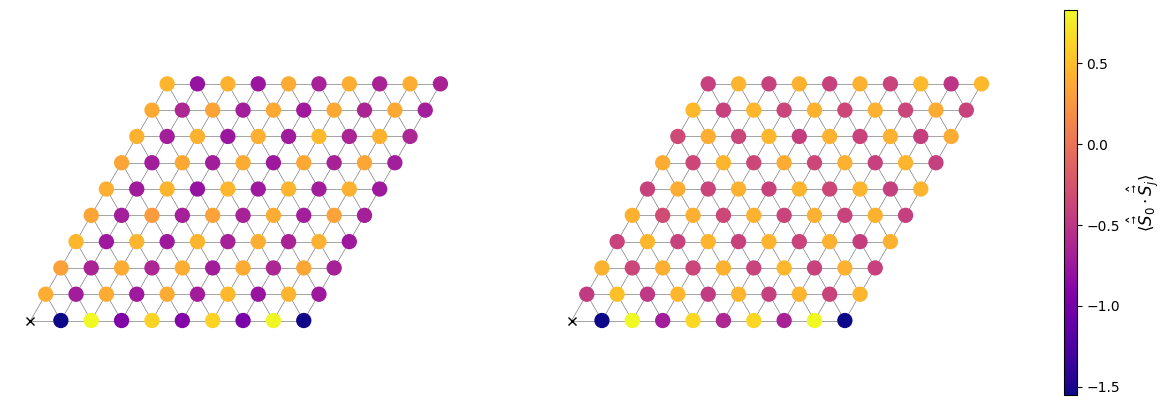

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)
# Plot for vit52_J2_sign
# axes[0].set_title(r'Spin-Spin Correlation: $J_2$ Sign')
axes[0].set_xlabel('x-direction')
axes[0].set_ylabel('y-direction')
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis('off')  # Remove the coordinate frame

for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    axes[0].plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

axes[0].scatter(xcoords[1:], ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_reflect']), cmap='plasma', s=100)
axes[0].plot(xcoords[0], ycoords[0], marker='x', color='black')  # Mark the reference node

# Plot for vit52_J3_sign
# axes[1].set_title(r'Spin-Spin Correlation: $J_3$ Sign')
axes[1].set_xlabel('x-direction')
axes[1].set_aspect('equal', adjustable='box')
axes[1].axis('off')  # Remove the coordinate frame

for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    axes[1].plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)


scatter = axes[1].scatter(xcoords[1:], ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_J3_reflect']), cmap='plasma', s=100)
axes[1].plot(xcoords[0], ycoords[0], marker='x', color='black')  # Mark the reference node

# Shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', shrink=0.5, aspect=30, pad=0.05)
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot \hat{\vec{S}}_j \rangle$', fontsize=12)

# plt.tight_layout()
plt.savefig(fname='SpinSpin_Corrs_vit52_J2Left_J3Right_sign_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


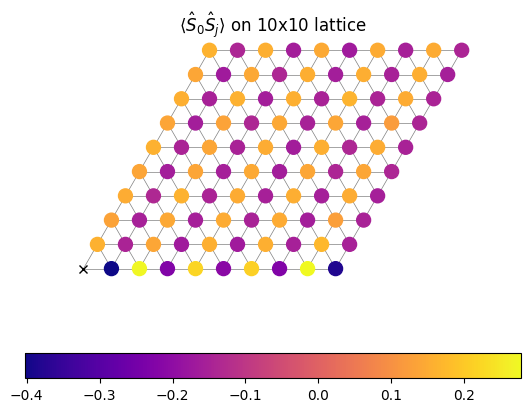

In [21]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ on 10x10 lattice', loc='center')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_reflect']), cmap='plasma', s=100, label=' α=1')
cbar = plt.colorbar(orientation='horizontal', pad=0.2)
# cbar.set_label(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)

plt.show()

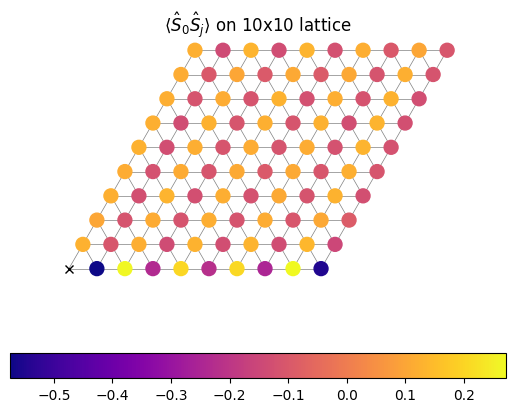

In [22]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ on 10x10 lattice', loc='center')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_nl6']), cmap='plasma', s=100, label=' α=1')
cbar = plt.colorbar(orientation='horizontal', pad=0.2)
# cbar.set_label(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)

plt.show()

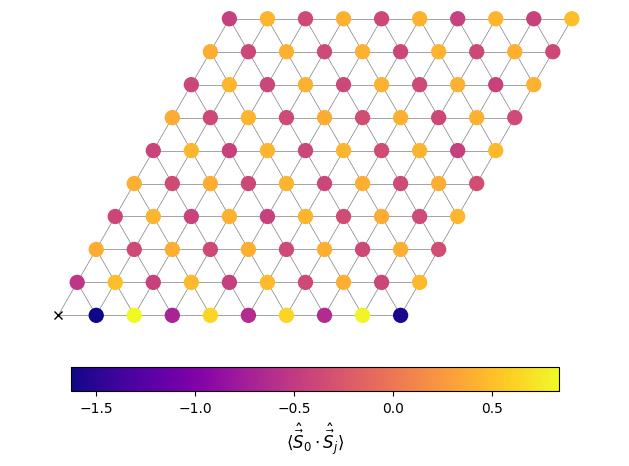

In [29]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
# plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit52 $J_3$ on 10x10 lattice', loc='center')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
sc = plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit52_J3']), cmap='plasma', s=100, label=' α=1')
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, shrink=0.8)
  # Adjust shrink to control size
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)
plt.tight_layout()

plt.savefig(fname='SpinSpin_Corrs_vit52_J3_sign.png', dpi=300, bbox_inches='tight')
plt.show()

## Structure Factor

In [41]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)

In [42]:
ks = FourierPoints_In_BrioullinZone(10, 100)

In [27]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = sublatt_J2

sss, ss_err = Create_SpinSpin_Vec(vs_vit_reflect,hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_vit52_ref, Sk_errs_ref = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)


In [40]:
# with open('StructureFactor_vit52_reflect.pickle', 'wb') as handle:
#     pickle.dump((Sk_vit52_ref, ks), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('StructureFactor_vit52_reflect.pickle', 'rb') as handle:
    Sk_vit52_ref, ks = pickle.load(handle)

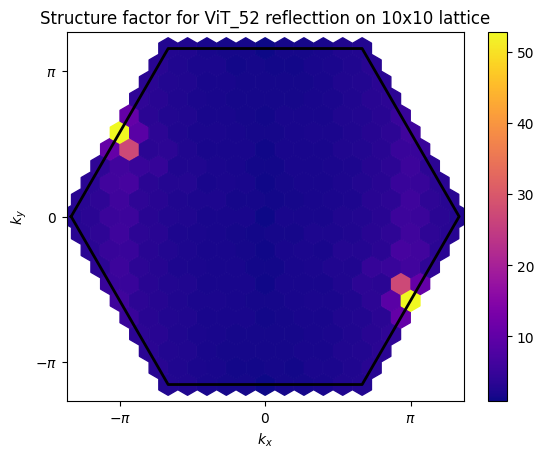

In [33]:
thickness =  24000 / L**2 
plt.title(r'Structure factor for ViT_52 reflecttion on 10x10 lattice')
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52.real, cmap='plasma', s=thickness, marker='h')
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52_ref.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()


In [ ]:
# ds = Create_Differences(TriGraph)
# sss, ss_err = Create_SpinSpin_Vec(vs_vit,hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True)
# # FourierPoints_In_BrioullinZone
# Sk_vit52, Sk_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)


In [29]:
with open('StructureFactor_vit52_SS_values.pickle', 'wb') as f:
    pickle.dump(Sk_vit52, f)
    
with open('StructureFactor_vit52_SS_errors.pickle', 'wb') as f:
    pickle.dump(Sk_errs, f)

In [39]:
with open('StructureFactor_vit52_SS_values.pickle', 'rb') as handle:
    test_values = pickle.load(handle)

In [18]:
print(np.where(np.all(np.isclose(ks , (3.14159, 0.362759)), axis=1)))

print(test_values[298])

(array([298]),)
(5.224093973949614+0.002657871986226654j)


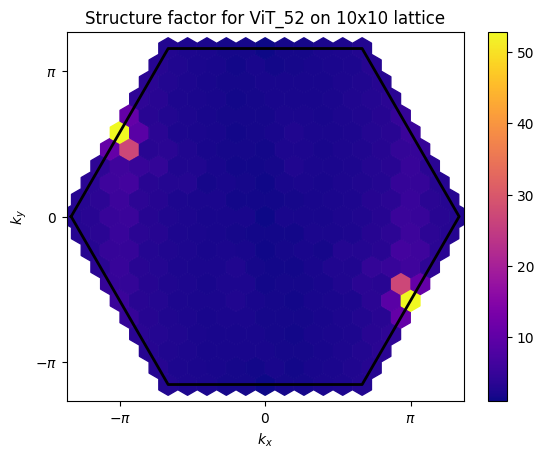

In [24]:
thickness =  24000 / L**2 
plt.title(r'Structure factor for ViT_52 on 10x10 lattice')
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52.real, cmap='plasma', s=thickness, marker='h')
plt.scatter(ks[:,0], ks[:,1], c=test_values.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()


In [34]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = sublattice(L)

sss, ss_err = Create_SpinSpin_Vec(vs_vit_J3,hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_vit52_J3, Sk_errs_J3 = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)


In [43]:
# with open('StructureFactor_vit52_J3.pickle', 'wb') as handle:
#     pickle.dump((Sk_vit52_J3, Sk_errs_J3), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('StructureFactor_vit52_J3.pickle', 'rb') as handle:
    Sk_vit52_J3, Sk_errs_J3 = pickle.load(handle)

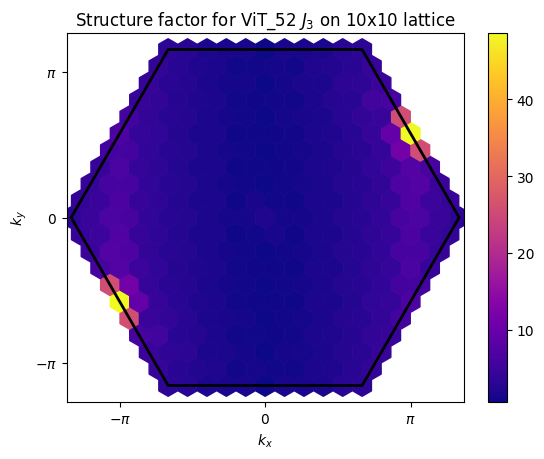

In [37]:
thickness =  24000 / L**2 
plt.title(r'Structure factor for ViT_52 $J_3$ on 10x10 lattice')
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52.real, cmap='plasma', s=thickness, marker='h')
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52_J3.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()

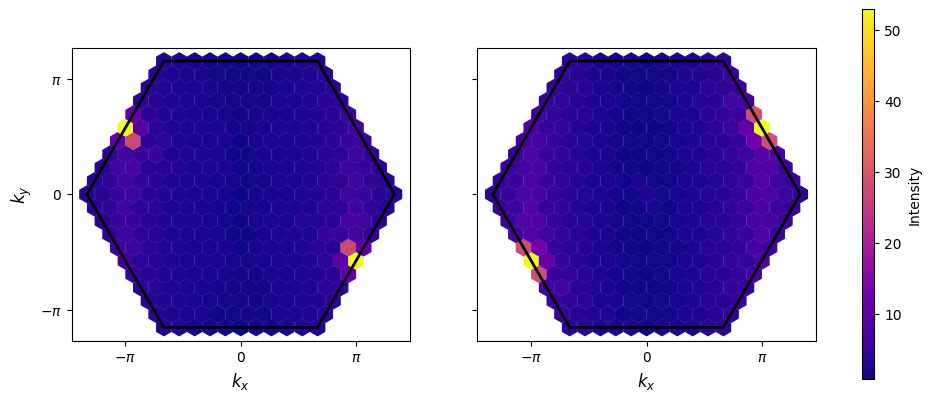

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=True)
thickness =  14000 / L**2 

# Plot Sk_vit52_J3
sc1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_vit52_ref.real, cmap='plasma', s=thickness, marker='h')
axes[0].plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# axes[0].set_title(r'Structure factor for ViT_52 $J_3$')
axes[0].set_xlabel(r'$k_x$', fontsize=12)
axes[0].set_ylabel(r'$k_y$', fontsize=12)
axes[0].set_aspect('equal')  # Ensure equal aspect ratio

# Plot Sk_vit52
sc2 = axes[1].scatter(ks[:, 0], ks[:, 1], c=Sk_vit52_J3.real, cmap='plasma', s=thickness, marker='h')
axes[1].plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# axes[1].set_title(r'Structure factor for ViT_52')
axes[1].set_xlabel(r'$k_x$', fontsize=12)
axes[1].set_aspect('equal')  # Ensure equal aspect ratio

# Shared colorbar on the right
cbar = fig.colorbar(sc1, ax=axes, orientation='vertical', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('Intensity')

# Set ticks and limits
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
for ax in axes:
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    # ax.set_xlim(-np.pi, np.pi)
    # ax.set_ylim(-np.pi, np.pi)

plt.savefig(fname='StructureFactor_vit52_J3right_J2left.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
np.max(test_values)

Array(52.84747676-0.02129175j, dtype=complex128)

In [20]:
ds = Create_Differences(TriGraph)
ss_rbm, ss_rbm_err = Create_SpinSpin_Vec(vs_rbm2_SS, hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_rbm2, Sk_rbm2_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_rbm, hi2d.size, ss_rbm_err)

In [21]:
with open('StructureFactor_rbm2_SS_values.pickle', 'wb') as f:
    pickle.dump(Sk_rbm2, f)
with open('StructureFactor_rbm2_SS_errors.pickle', 'wb') as f:
    pickle.dump(Sk_rbm2_errs, f)

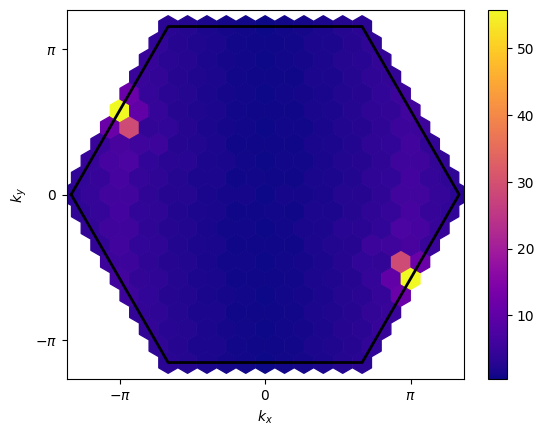

In [22]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks[:,0], ks[:,1], c=Sk_rbm2.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()

In [27]:
M_ind = np.where(np.all(np.isclose(ks , (np.pi, np.pi/np.sqrt(3))), axis=1))
Sk_rbm2[M_ind]

Array([5.89123679+0.00033649j], dtype=complex128)

In [28]:
Sk_rbm2[np.where(np.all(np.isclose(ks , (3.14159, 0.362759)), axis=1))]

Array([6.15863579+0.00030619j], dtype=complex128)

In [15]:
ks = FourierPoints_In_BrioullinZone(10, 100)
ds = Create_Differences(TriGraph)
ss_nl6, ss_nl6_err = Create_SpinSpin_Vec(vs_vit_nl6, hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_nl6, Sk_nl6_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_nl6, hi2d.size, ss_nl6_err)

In [16]:
with open('StructureFactor_vit_SS_nl6.pickle', 'wb') as f:
    pickle.dump(Sk_nl6, f)

with open('StructureFactor_vit_SS_nl6_errors.pickle', 'wb') as f:
    pickle.dump(Sk_nl6_errs, f)

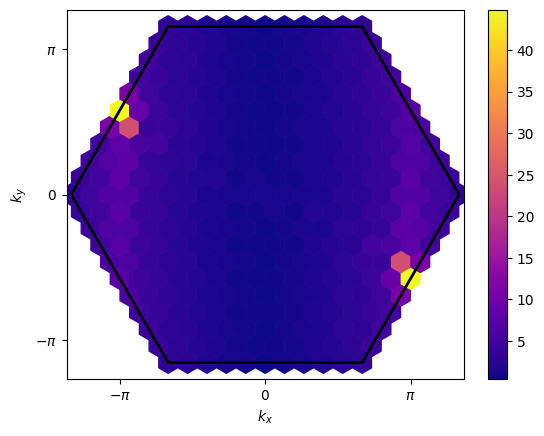

In [17]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks[:,0], ks[:,1], c=Sk_nl6.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()

In [25]:
# [ 3.14159265,  0.36275987]
print(Sk_nl6[np.where(np.all(np.isclose(ks , (3.14159, -0.362759)), axis=1))])
print(Sk_nl6_errs[np.where(np.all(np.isclose(ks , (3.14159, -0.362759)), axis=1))])

print(np.max(Sk_nl6))

[7.58052078-0.00124691j]
[0.02805897]
(44.8603479869659+0.005857498045870832j)


## Attention maps

In [40]:
# vs_vit.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0'].keys()
alpha10 = vs_vit.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha']
alpha10.shape

(8, 10)

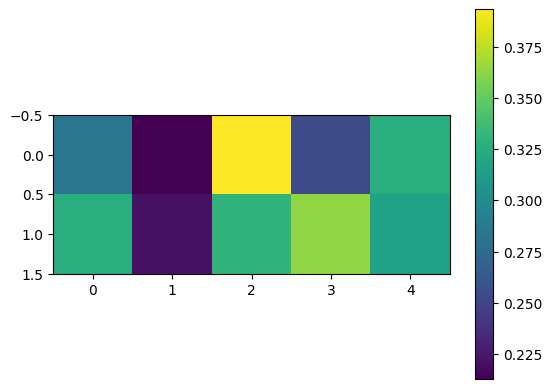

In [45]:
alpha10mean = jnp.mean(jnp.abs(alpha10), axis=0)
plt.imshow(alpha10mean.reshape(2,5), cmap='viridis')
plt.colorbar()